### Théo Cornille - Luc Gibaud - Cédric des Lauriers

# Débruitage d'image : BM3D, implémentations et expérimentations

### Rappel des consignes : 

Le livrable contiendra typiquement :
- une partie implémentation (partielle ou totale)
- une partie expérimentale (avec des résultats d'expérience)
- un rapport qui décrit :
    - le travail effectué
    - la problématique
    - donne le pseudo code de l'algorithme
    - présente les résultats expérimentaux
    - donne une analyse critique


Il faudra rendre les travaux avant le 07/01/2019 *au plus tard*. 

### Source utilisées : 
- https://www.ipol.im/pub/art/2012/l-bm3d/article.pdf
- http://mcolom.perso.math.cnrs.fr/download/articles/acta_numerica.pdf?fbclid=IwAR23wScDWCFEZhrtUWb7j1tI6xjOyUpUoEa8_EEbM2mFjxiKhGljBGHs_4o
- https://www.ipol.im/pub/art/2013/16/article.pdf (Comparaison entre BM3D et non-local Bayes)

- https://github.com/liuhuang31/BM3D-Denoise/blob/master/BM3D.py


### Lien overleaf : 
- https://www.overleaf.com/6472126525mqdrghptnykh


## I. Implémentation
### a) BM3D - Etape 1

In [1]:
# Si nécessaire, pour installer cv2 : !pip install opencv-python

In [2]:
#Import des librairies nécessaires
import numpy as np
import cv2

In [3]:
# Fonction qui définit la distance quadratique entre deux "patches"
dist = lambda a, b, k : np.linalg.norm(a - b)**2 / (k**2)

In [4]:
# Selectionne la zone de recherche
def select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_):
    row_min = 0 if row - lambda_//2 < 0 else row - lambda_//2
    row_max = n_rows if row + lambda_//2 + lambda_%2 > n_rows else row + lambda_//2 + lambda_%2
    column_min = 0 if column - lambda_//2 < 0 else column - lambda_//2
    column_max = n_columns if column + lambda_//2 + lambda_%2 > n_columns else column + lambda_//2 + lambda_%2
    
    if column_min == 0:
        column_max = lambda_
    if column_max == n_columns: 
        column_min = column_max - lambda_
    if row_min == 0:
        row_max = lambda_
    if row_max == n_columns: 
        row_min = row_max - lambda_
    return u_noised[row_min : row_max, column_min : column_max]

In [5]:
#Défini la fonction gamma utilisée dans la première étape de BM3D
def gamma(x, lambda_3D, sigma):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.abs(x[i,j]) <= lambda_3D * sigma:
                x[i,j] = 0
    return x

In [6]:
# La première étape de débruitage
def BM3D_first_part(u_noised, sigma):

    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_denoised = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    k, lambda_, N_max, s, lambda_3D  = 8, 39, 16, 3 ,2.7
    tau = 5000 if sigma > 40 else 2500
    
    for row in range(k//2, n_rows - k//2 - k%2 + 1, s):
        for column in range(k//2, n_columns - k//2 - k%2 + 1, s):
            P = u_noised[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]

            # Grouping
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_)
            L = []
            for i in range(search_zone.shape[0] - k + 1):
                for j in range(search_zone.shape[1] - k + 1):
                    Q = search_zone[i : i  + k, j : j + k]
                    dist_ = dist(P,Q,k)
                    if dist_ < tau:
                        L.append((Q, dist_))
            L.sort(key = lambda x : x[1])
            if len(L) > N_max:
                N_chosen = N_max
            else :
                p = 0
                while 2**(p+1) <= len(L):
                    p +=1
                N_chosen = 2**p
            group_3D = np.array(L[:N_chosen])[:,0]  
                
            # Collaborative Filtering
            for i in range(len(group_3D)):
                tau_3D = cv2.dct(group_3D[i].astype(np.float64))
                group_3D[i] = cv2.idct(gamma(tau_3D, lambda_3D, sigma))
            
            # Aggregation
            for Q in group_3D:
                for i in range(Q.shape[0]):
                    for j in range(Q.shape[1]):
                        V[row - k//2 + i, column - k//2 + j] += Q[i, j]/ max(N_chosen, 1)
                        DELTA[row - k//2 + i, column - k//2 + j] += 1./ max(N_chosen, 1)
            
    u_denoised = (V / DELTA)
    
    return u_denoised

### b) BM3D - Etape 2

In [7]:
# La seconde étape de débruitage
def BM3D_second_part(u_noised, u_basic, sigma):
    
    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_denoised = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    k, lambda_, N_max, s  = 8, 39, 32, 3
    tau = 3500 if sigma > 40 else 400
    
    for row in range(k//2, n_rows - k//2 - k%2 + 1, s):
        for column in range(k//2, n_columns - k//2 - k%2 + 1, s):
            P = u_noised[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]
            P_basic = u_basic[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]

            # Grouping
            search_zone_basic = select_search_zone(u_basic, row, column, n_rows, n_columns, lambda_)
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_)
            L_basic = []
            L = []
            for i in range(search_zone_basic.shape[0] - k + 1):
                for j in range(search_zone_basic.shape[1] - k + 1):
                    Q = search_zone_basic[i : i  + k, j : j + k]
                    dist_ = dist(P_basic,Q,k)
                    if dist_ < tau:
                        L_basic.append((Q, dist_))
                        L.append((search_zone[i : i  + k, j : j + k], dist_))
            L_basic.sort(key = lambda x : x[1])
            L.sort(key = lambda x : x[1])
            if len(L_basic) > N_max: 
                N_chosen = N_max
            else :
                p = 0
                while 2**(p+1) <= len(L):
                    p +=1
                N_chosen = 2**p
            group_3D_basic = np.array(L_basic[:N_chosen])[:,0]  
            group_3D = np.array(L[:N_chosen])[:,0]
                
            # Collaborative Filtering
            Wp = []
            P_wien = []
            for i in range(len(group_3D)):          
                tau_wien_basic = cv2.dct(group_3D_basic[i].astype(np.float64))
                tau_wien = cv2.dct(group_3D[i].astype(np.float64))
                Wp.append(tau_wien_basic**2 / (tau_wien_basic**2 + sigma**2))
                P_wien.append(cv2.idct(Wp[-1] * tau_wien))
                
            # Aggregation
            for n in range(len(group_3D)):
                Q = P_wien[n]
                for i in range(Q.shape[0]):
                    for j in range(Q.shape[1]): 
                        V[row - k//2 + i, column - k//2 + j] += Q[i, j]/ np.linalg.norm(Wp[n])**2
                        DELTA[row - k//2 + i, column - k//2 + j] += 1./ np.linalg.norm(Wp[n])**2
                        
    u_denoised = (V / DELTA)     
            
    return u_denoised

### c) BM3D - Algorithme général

In [8]:
# L'algorithme général
def BM3D(u_noised, sigma):
    
    u_denoised_after_step1 = BM3D_first_part(u_noised, sigma)
    BM3D_second_part(u_noised, u_denoised_after_step1, sigma)
    
    return u_denoised

## II. Expérimentation

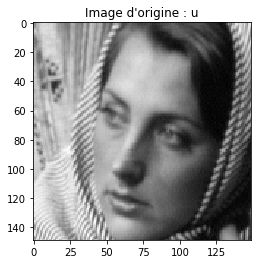

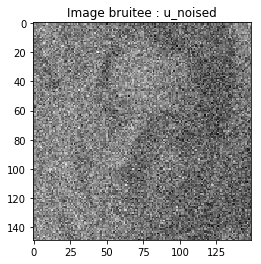

In [10]:
import matplotlib.pyplot as plt

# On importe u une image sans bruit
u = (plt.imread("barbara.png") * 255).astype(int)[25:174, 300:449]
plt.imshow(u, plt.cm.gray)
plt.title("Image d'origine : u")
plt.show()

u_shape = u.shape

# On crée artificiellement du bruit avec un écart-type de 5 (sigma = 5)
np_round = np.vectorize(lambda x : int(round(x,0)))
u_noised = u + np_round(np.random.normal(0, 100, ((u.shape[0], u.shape[1]))))
plt.imshow(u_noised, plt.cm.gray)
plt.title("Image bruitee : u_noised")
plt.show()

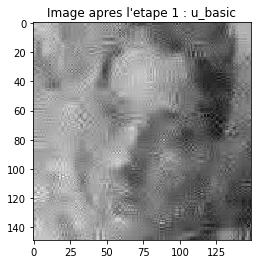

In [11]:
u_basic = BM3D_first_part(u_noised, 100) # sigma = 10 car l'écart-type = 10

plt.imshow(u_basic, plt.cm.gray)
plt.title("Image apres l'etape 1 : u_basic")
plt.show()

In [ ]:
u_denoised = BM3D_second_part(u_noised, u_basic, 100) # sigma = 10 car l'écart-type = 10

plt.imshow(u_denoised, plt.cm.gray)
plt.title("Image debruitee apres les etapes 1 et 2: u_denoised")
plt.show()